### Import packages

In [160]:
import json
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

import plotly.express as px
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None  # default='warn'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

### Import Statewise Covid19 data from api

In [68]:
#import data for statewise total cases till date 

#https://stackoverflow.com/questions/67642291/i-am-not-getting-any-output-in-web-scraping-using-beautiful-soup-and-python-and
#Current day numbers across districts and states.

import requests
import pandas as pd

response = requests.get("https://api.covid19india.org/v4/min/data.min.json")
if response.status_code == 200:
    current_day_numbers = response.json()
    DATE = []
    STATE = []
    POPULATION = []
    TOTAL_CASES = []
    DECEASED = []
    RECOVERED = []
    TESTED = []
    VACCINATED_DOSE1 = []
    VACCINATED_DOSE2 = []

    for state in current_day_numbers.keys():
        DATE.append(current_day_numbers[state]["meta"]["date"])
        STATE.append(state)
        POPULATION.append(current_day_numbers[state]["meta"]["population"])
        TOTAL_CASES.append(current_day_numbers[state]["total"]["confirmed"])
        DECEASED.append(current_day_numbers[state]["total"]["deceased"])
        RECOVERED.append(current_day_numbers[state]["total"]["recovered"])
        TESTED.append(current_day_numbers[state]["total"]["tested"])
        VACCINATED_DOSE1.append(current_day_numbers[state]["total"]["vaccinated1"])
        VACCINATED_DOSE2.append(current_day_numbers[state]["total"]["vaccinated2"])

    Covid19_data = pd.DataFrame(
        {
            "DATE": DATE,
            "STATE/UT": STATE,
            "POPULATION":POPULATION,
            "TOTAL_CASES": TOTAL_CASES,
            "DECEASED": DECEASED,
            "RECOVERED": RECOVERED,
            "TESTED": TESTED,
            "VACCINATED_DOSE1": VACCINATED_DOSE1,
            "VACCINATED_DOSE2": VACCINATED_DOSE2,
        }
    )
    #print(data.head())

else:
    print("Error while calling API: {}".format(response.status_code, response.reason))

### Data Check and manipulation

In [69]:
#Print a sample data
Covid19_data.head()

,DATE,STATE/UT,POPULATION,TOTAL_CASES,DECEASED,RECOVERED,TESTED,VACCINATED_DOSE1,VACCINATED_DOSE2
0,2021-08-01,AN,397000,7539,129,7403,440870,209744,91633
1,2021-08-01,AP,52221000,1968462,13395,1934048,24648899,16301408,5586517
2,2021-08-01,AR,1504000,48260,231,44354,942207,672715,174809
3,2021-08-01,AS,34293000,566982,5275,549065,18722233,8878074,1949091
4,2021-08-01,BR,119520000,724880,9644,714801,37498366,20782782,3919266


In [70]:
#Note:
#population: This gives the population of the state (based on NCP projections)

#There is some issue with the population as the sum crosses 2 billion which is not correct
Total_population = Covid19_data['POPULATION'].sum()

print(Total_population) # Coming to 2 billion

2665798000


In [71]:
#Print the structure
Covid19_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DATE              37 non-null     object
 1   STATE/UT          37 non-null     object
 2   POPULATION        37 non-null     int64 
 3   TOTAL_CASES       37 non-null     int64 
 4   DECEASED          37 non-null     int64 
 5   RECOVERED         37 non-null     int64 
 6   TESTED            37 non-null     int64 
 7   VACCINATED_DOSE1  37 non-null     int64 
 8   VACCINATED_DOSE2  37 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 2.7+ KB


In [72]:
#Changing DATE column format
Covid19_data['DATE']= pd.to_datetime(Covid19_data['DATE'], format = '%Y-%m-%d')

In [73]:
#Change state names from abbrevations to full name
dict_states={'WB': 'West Bengal', 'DL': 'Delhi', 'KL': 'Kerala', 'PB': 'Punjab', 'AP':'Andhra Pradesh', 
             'TN': 'Tamil Nadu', 'KA': 'Karnataka', 'JK': 'Jammu and Kashmir', 'UP': 'Uttar Pradesh', 'MP': 'Madhya Pradesh', 
             'MH': 'Maharashtra', 'BR': 'Bihar', 'HR': 'Haryana', 'OR': 'Orissa', 'RJ': 'Rajasthan', 'GJ': 'Gujarat', 
             'HP': 'Himachal Pradesh', 'AS': 'Assam', 'TG': 'Telangana', 'JH': 'Jharkhand', 'ML': 'Meghalaya', 
             'UT': 'Uttarakhand', 'CH': 'Chandigarh', 'CT': 'Chhattisgarh', 'LA': 'Lakshadweep', 'TR': 'Tripura', 
             'PY': 'Pondicherry', 'GA': 'Goa', 'AR': 'Arunachal Pradesh', 'DN': 'Dadra and Nagar Haveli', 
             'NL': 'Nagaland', 'SK':'Sikkim', 'AN': 'Andaman and Nicobar Islands', 'MN': 'Manipur', 'MZ': 'Mizoram', 
             'LD': 'Lakshadweep', 'TT': 'Total'}

Covid19_data = Covid19_data.replace({'STATE/UT':dict_states})

In [74]:
#Print a sample data
Covid19_data.head()

,DATE,STATE/UT,POPULATION,TOTAL_CASES,DECEASED,RECOVERED,TESTED,VACCINATED_DOSE1,VACCINATED_DOSE2
0,2021-08-01,Andaman and Nicobar Islands,397000,7539,129,7403,440870,209744,91633
1,2021-08-01,Andhra Pradesh,52221000,1968462,13395,1934048,24648899,16301408,5586517
2,2021-08-01,Arunachal Pradesh,1504000,48260,231,44354,942207,672715,174809
3,2021-08-01,Assam,34293000,566982,5275,549065,18722233,8878074,1949091
4,2021-08-01,Bihar,119520000,724880,9644,714801,37498366,20782782,3919266


In [75]:
#Adding column for Total Active cases
Covid19_data['ACTIVE'] = Covid19_data['TOTAL_CASES'] - Covid19_data['DECEASED'] - Covid19_data['RECOVERED']

In [76]:
#Adding column for Total Vaccinated
Covid19_data['TOTAL_VACCINATION'] = Covid19_data['VACCINATED_DOSE1'] + Covid19_data['VACCINATED_DOSE2']

In [77]:
#Add a row with Total values
#Covid19_data.loc['Total']= Covid19_data.sum(numeric_only=True)
#print(Covid19_data.loc['Total',:])

### Create two dataset
    1) Statewise vaccine dataset
    2) Statewise staus dataset

In [78]:
#Statewise Vaccination data
Covid19_vacination_data = Covid19_data[['STATE/UT', 'POPULATION','TOTAL_VACCINATION', 'VACCINATED_DOSE1', 'VACCINATED_DOSE2']]

In [79]:
Covid19_vacination_data.head()

,STATE/UT,POPULATION,TOTAL_VACCINATION,VACCINATED_DOSE1,VACCINATED_DOSE2
0,Andaman and Nicobar Islands,397000,301377,209744,91633
1,Andhra Pradesh,52221000,21887925,16301408,5586517
2,Arunachal Pradesh,1504000,847524,672715,174809
3,Assam,34293000,10827165,8878074,1949091
4,Bihar,119520000,24702048,20782782,3919266


In [80]:
#Creating percentage columns
Covid19_vacination_data['PERC_VACCINATED'] = (Covid19_vacination_data['TOTAL_VACCINATION']/Covid19_vacination_data['POPULATION'])*100


Covid19_vacination_data['PERC_VACCINATED_DOSE1'] = (Covid19_vacination_data['VACCINATED_DOSE1']/Covid19_vacination_data['POPULATION'])*100


Covid19_vacination_data['PERC_VACCINATED_DOSE2'] = (Covid19_vacination_data['VACCINATED_DOSE2']/Covid19_vacination_data['POPULATION'])*100


In [81]:
Covid19_vacination_data.head()

,STATE/UT,POPULATION,TOTAL_VACCINATION,VACCINATED_DOSE1,VACCINATED_DOSE2,PERC_VACCINATED,PERC_VACCINATED_DOSE1,PERC_VACCINATED_DOSE2
0,Andaman and Nicobar Islands,397000,301377,209744,91633,75.91,52.83,23.08
1,Andhra Pradesh,52221000,21887925,16301408,5586517,41.91,31.22,10.70
2,Arunachal Pradesh,1504000,847524,672715,174809,56.35,44.73,11.62
3,Assam,34293000,10827165,8878074,1949091,31.57,25.89,5.68
4,Bihar,119520000,24702048,20782782,3919266,20.67,17.39,3.28


In [82]:
#Add a row with Total values
#print(Covid19_vacination_data.loc['Total',:])

In [83]:
Covid19_data.columns

Index(['DATE', 'STATE/UT', 'POPULATION', 'TOTAL_CASES', 'DECEASED',
       'RECOVERED', 'TESTED', 'VACCINATED_DOSE1', 'VACCINATED_DOSE2', 'ACTIVE',
       'TOTAL_VACCINATION'],
      dtype='object')

In [84]:
#Statewise Status data
Covid19_status_data = Covid19_data[['STATE/UT', 'POPULATION','TOTAL_CASES', 'ACTIVE', 'RECOVERED', 'DECEASED']]

In [85]:
#Creating percentage columns
Covid19_status_data['ACTIVE_RATIO'] = (Covid19_status_data['ACTIVE']/Covid19_status_data['TOTAL_CASES'])*100


Covid19_status_data['RECOVERED_RATIO'] = (Covid19_status_data['RECOVERED']/Covid19_status_data['TOTAL_CASES'])*100


Covid19_status_data['DECEASED_RATIO'] = (Covid19_status_data['DECEASED']/Covid19_status_data['TOTAL_CASES'])*100


In [86]:
Covid19_status_data.head()

,STATE/UT,POPULATION,TOTAL_CASES,ACTIVE,RECOVERED,DECEASED,ACTIVE_RATIO,RECOVERED_RATIO,DECEASED_RATIO
0,Andaman and Nicobar Islands,397000,7539,7,7403,129,0.09,98.20,1.71
1,Andhra Pradesh,52221000,1968462,21019,1934048,13395,1.07,98.25,0.68
2,Arunachal Pradesh,1504000,48260,3675,44354,231,7.62,91.91,0.48
3,Assam,34293000,566982,12642,549065,5275,2.23,96.84,0.93
4,Bihar,119520000,724880,435,714801,9644,0.06,98.61,1.33


In [87]:
#Add a row with Total values
#print(Covid19_status_data.loc['Total',:])

### Distribution of cases

In [88]:
# cases_grouped = Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total'].groupby('STATE/UT')['ACTIVE'].sum().sort_values(ascending=False).to_frame()
# cases_grouped.style.background_gradient(cmap='Reds')

In [194]:
#Top 5 Active states
Top_active = Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total'].groupby('STATE/UT')['ACTIVE'].sum().sort_values(ascending=False).to_frame()
Top_5_active = Top_active[0:5:]
Top_5_active.style.background_gradient(cmap='Reds')

,ACTIVE
STATE/UT,
Kerala,167890
Maharashtra,82350
Karnataka,24168
Andhra Pradesh,21019
Tamil Nadu,20524


In [195]:
#Top 5 states with most cases
Top_cases = Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total'].groupby('STATE/UT')['TOTAL_CASES'].sum().sort_values(ascending=False).to_frame()
Top_5_cases = Top_cases[0:5:]
Top_5_cases.style.background_gradient(cmap='Reds')

,TOTAL_CASES
STATE/UT,
Maharashtra,6310194
Kerala,3411489
Karnataka,2906999
Tamil Nadu,2561587
Andhra Pradesh,1968462


In [196]:
#Top 5 states with recovered cases
Top_recovered = Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total'].groupby('STATE/UT')['RECOVERED'].sum().sort_values(ascending=False).to_frame()
Top_5_recovered = Top_recovered[0:5:]
Top_5_recovered.style.background_gradient(cmap='Reds')

,RECOVERED
STATE/UT,
Maharashtra,6094896
Kerala,3226761
Karnataka,2846244
Tamil Nadu,2506961
Andhra Pradesh,1934048


In [61]:
# #Retreiving Latitude and Longitude coordinates
# info = pd.read_html("http://www.quickgs.com/latitudinal-and-longitudinal-extents-of-india-indian-states-and-cities/") 

# #convering the table data into DataFrame
# coordinates = pd.DataFrame(info[0])

# coordinates.head()

In [175]:
#Get the date 
date = Covid19_data['DATE'][0].strftime('%b %d,%Y')

### Total Active cases

In [182]:
fig = px.bar(Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total'].sort_values('ACTIVE', ascending=False).sort_values('ACTIVE', ascending=True), 
             x="ACTIVE", y="STATE/UT", 
             title= f'Total Active Cases as of {date}', 
             text='ACTIVE', 
             orientation='h', 
             width=1000, height=700, range_x = [0, max(Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total']['ACTIVE']) + 10000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='inside')

fig.update_layout(plot_bgcolor='rgb(250, 242, 242)')
fig.show()

### Confirmed vs Recovered figures

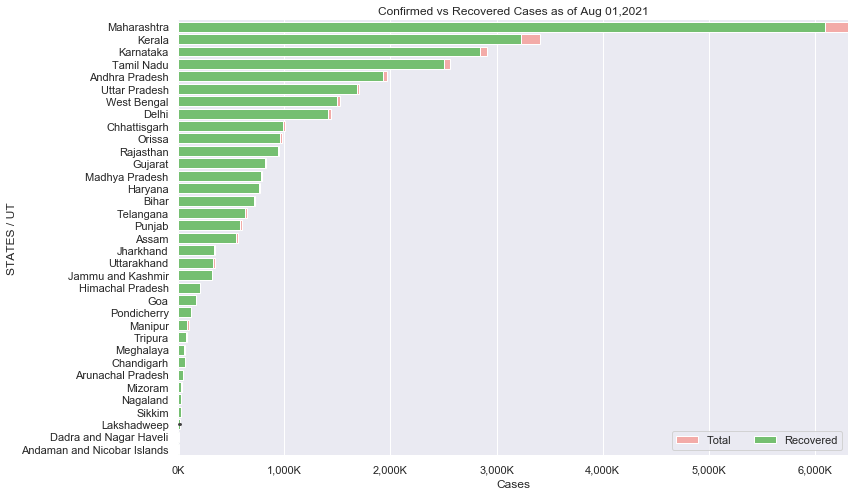

In [178]:
f, ax = plt.subplots(figsize=(12, 8))
data = Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total']
data = data[['STATE/UT','TOTAL_CASES','RECOVERED','DECEASED']]
data.sort_values('TOTAL_CASES',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="TOTAL_CASES", y="STATE/UT", data=data,
            label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="RECOVERED", y="STATE/UT", data=data,
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, max(Covid19_status_data[Covid19_status_data['STATE/UT'] != 'Total']['TOTAL_CASES'])), ylabel="STATES / UT",
       xlabel="Cases", title = f'Confirmed vs Recovered Cases as of {date}')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
sns.despine(left=True, bottom=True)


### Total vaccinated vs Dose 2 Vaccinated

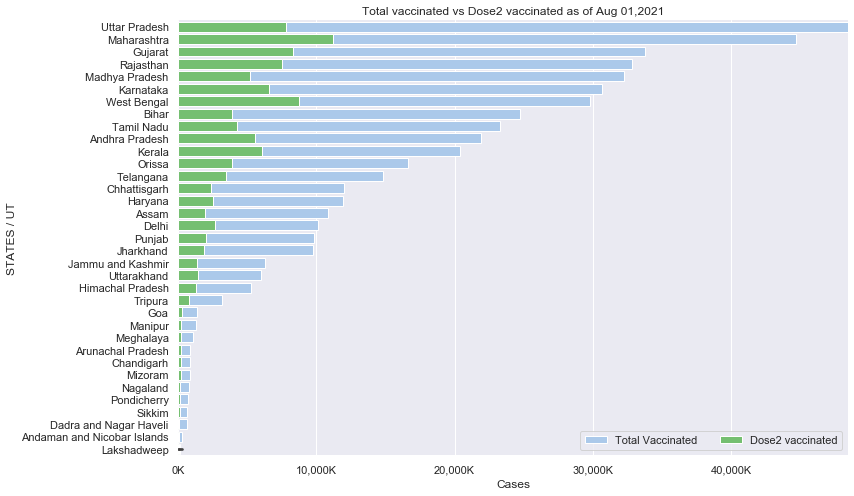

In [200]:
f, ax = plt.subplots(figsize=(12, 8))
data = Covid19_vacination_data[Covid19_vacination_data['STATE/UT'] != 'Total']
data = data[['STATE/UT','TOTAL_VACCINATION', 'VACCINATED_DOSE2']]
data.sort_values('TOTAL_VACCINATION',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="TOTAL_VACCINATION", y="STATE/UT", data=data,
            label="Total Vaccinated", color="b")

sns.set_color_codes("muted")
sns.barplot(x="VACCINATED_DOSE2", y="STATE/UT", data=data,
            label="Dose2 vaccinated", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, max(Covid19_vacination_data[Covid19_vacination_data['STATE/UT'] != 'Total']['TOTAL_VACCINATION'])), ylabel="STATES / UT",
       xlabel="Cases", title = f'Total vaccinated vs Dose2 vaccinated as of {date}')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
sns.despine(left=True, bottom=True)